# Source Reconstruction


In [1]:
# Setup and imports
import re
from pathlib import Path
import pickle

import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
from IPython.display import clear_output
from mne_connectivity import envelope_correlation
from mne.time_frequency import psd_array_welch

In [39]:
sfreq = 512 # we resample the data to 512 Hz
frequencies = {'delta': (1, 4),
               'theta': (4, 8),
               'alpha': (8, 13),
               'beta': (13, 30),
               'lowgamma': (30, 42)  
}
# Helper functions
def creat_raw_from_epochs(epochs):
    data = np.hstack(epochs.get_data())
    info = mne.create_info(ch_names=epochs.ch_names,
                           ch_types='eeg',
                           sfreq=epochs.info['sfreq'])

    raw = mne.io.RawArray(data, info)
    raw.set_channel_types({'ECG': 'ecg', 'EOG1': 'eog', 'EOG2': 'eog'})
    return raw

def make_forward():
    # fsaverage files
    fs_dir = Path('data/fsaverage')

    # The files live in:
    trans = 'fsaverage'  # MNE has a built-in fsaverage transformation
    src = fs_dir / 'bem' / 'fsaverage-ico-4-src.fif' # use icosahedron4 with 6.2 mm source spacing
    src = mne.read_source_spaces(src)
    bem = fs_dir / 'bem' / 'fsaverage-5120-5120-5120-bem-sol.fif'
    
    path:Path = Path('data/clean_data')
    epochs_fname = path / 'sub-01_ses-01_task-baseline1_proc-clean_epo.fif'
    epochs = mne.read_epochs(epochs_fname, preload=True)
    epochs.resample(512)

    # create raw object
    raw = creat_raw_from_epochs(epochs)

    # insert channel positions
    montage = mne.channels.make_standard_montage('standard_1020')
    raw.set_montage(montage)

    # forward solution (the same across all subjects)
    fwd = mne.make_forward_solution(raw.info, trans=trans, src=src,
                                    bem=bem, eeg=True, mindist=5.0, n_jobs=-1, verbose=False)
    del src, bem
    return fwd

def make_inverse_4baseline(subject: str,
                           fwd: mne.forward.forward.Forward,
                           path = Path('data/clean_data')):
    
    epochs_fname = path / f'{subject}_ses-01_task-baseline1_proc-clean_epo.fif'
    epochs = mne.read_epochs(epochs_fname, preload=True)
    epochs.resample(512)
    
    # create raw object
    raw = creat_raw_from_epochs(epochs)

    # insert channel positions
    montage = mne.channels.make_standard_montage('standard_1020')
    raw.set_montage(montage)
    
    raw.set_eeg_reference('average', projection=True)
    
    # covariance matrix
    cov = mne.compute_raw_covariance(raw, method='auto', cv=5, n_jobs=-1)

    # inverse operator
    inv = mne.minimum_norm.make_inverse_operator(raw.info, fwd, cov, verbose=False)
    
    return inv

def get_labels(subject: str,
                     task: str,
                     atlas_labels: list,
                     inv: mne.minimum_norm.inverse.InverseOperator,
                     path:Path = Path('data/clean_data'),
                     ):
    # open data
    epochs_fname = path / f'{subject}_ses-01_task-{task}_proc-clean_epo.fif'
    epochs = mne.read_epochs(epochs_fname, preload=True)
    epochs.resample(512)
    
    montage = mne.channels.make_standard_montage('standard_1020')
    epochs.set_montage(montage)

    stc = mne.minimum_norm.apply_inverse_epochs(epochs,
                                                inv,
                                                method='eLORETA',
                                                lambda2=1./9.,
                                                verbose=False)
    
    label_ts = mne.extract_label_time_course(stc,
                                             atlas_labels,
                                             inv['src'],
                                             return_generator=False,
                                             verbose=False)
    
    return label_ts

def get_connectivity(label_ts,
                     frequencies: dict,
                     sfreq: int = sfreq
):
    def bp_gen(label_ts, fmin, fmax, sfreq):
        for ts in label_ts:
            yield mne.filter.filter_data(ts, sfreq=sfreq, l_freq=fmin, h_freq=fmax)
    
    # each segment in labels_ts is 1 second
    # To compute the connectivity, we want segments that its lenght is about 30 seconds (or a bit less)
    label_continious = np.hstack(np.array(label_ts))
    label_ts = np.array_split(label_continious, 10, axis=1)
    
    conns = {} 
    for bp in frequencies.keys():
        conn_obj = envelope_correlation(bp_gen(label_ts, frequencies[bp][0], frequencies[bp][1], sfreq),
                                               orthogonalize='pairwise')
        conn = conn_obj.combine()
        conn = conn.get_data(output='dense')[..., 0]
        conns[bp] = conn
        
    return conns

## Power Correlation on parcerllated source

In [360]:
# we will use Yeo2011 atlas (7 networks)
atlas_labels = mne.read_labels_from_annot('fsaverage',
                                          'Yeo2011_7Networks_N1000',
                                          subjects_dir='data/')

# forward solution (same across all subjects)
fwd = make_forward()

for subject_path in sorted(Path('data/clean_data').glob('*.fif')):

    subject, task = re.search('(.*)_ses.*_task-(.*)_proc.*', subject_path.stem).groups()
    
    output_path_conn = Path(f'data/connectivities/{subject}_task-{task}_conn-corr.pkl')
    output_path_labels = Path(f'data/parcellated_source_yeo7/{subject}_task-{task}_labels.npz')
    
    if output_path_labels.exists():
        continue
        
    print('>>>>>>>>', subject, task)
    if task == 'baseline1':
        # TODO use the experience in control instead of baseline to get the cov matrix.
        inv = make_inverse_4baseline(subject, fwd)
        
    elif 'induction' in task:
        continue
    
    else: 
        label_ts = get_labels(subject, task, atlas_labels, inv)
        
        np.savez_compressed(output_path_labels, labels=label_ts)
        
        # TODO extract the phase-based connectivity
        conns = get_connectivity(label_ts, frequencies)
        
        # with open(output_path_conn, 'wb') as f:
        #     pickle.dump(conns, f)
            
        del conns, labels_ts
        
        
    clear_output()

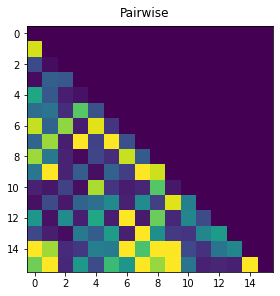

In [23]:
# visualization
def plot_corr(corr, title):
    fig, ax = plt.subplots(figsize=(4, 4), constrained_layout=True)
    ax.imshow(corr, cmap='viridis', clim=np.percentile(corr, [5, 95]))
    fig.suptitle(title)

conn = conn.get_data(output='dense')[..., 0]
plot_corr(conn, 'Pairwise')

### Prepare data for Classification

In [130]:
# create labels
# yeo2011 networks names
yeo17 = {
    'N1': 'Visual peripheral',
    'N2': 'Visual central',
    'N3': 'Somatomotor A',
    'N4': 'Somatomotor B',
    'N5': 'Dorsal attention A',
    'N6': 'Dorsal attention B',
    'N7': 'Ventral attention',
    'N8': 'Salience',
    'N9': 'Limbic A',
    'N10': 'Limbic B',
    'N11': 'Control C',
    'N12': 'Control A',
    'N13': 'Control B',
    'N14': 'Default D (Auditory)',
    'N15': 'Default C',
    'N16': 'Default A',
    'N17': 'Default B',
 }

yeo7 = {
    'N1': 'Visual',
    'N2': 'Somatomotor',
    'N3': 'DorsalAttention',
    'N4': 'VentralAttention',
    'N5': 'Limbic',
    'N6': 'Frontoparietal',
    'N7': 'Default',
    'mwall': 'Medial_Wall',
}

hemisferes = ['lh', 'rh']

# labels based on Yeo2011 atlas orders
labels = [yeo7[k]+'_'+ hemisferes[i] for k in yeo7.keys() for i in range(len(hemisferes))]

conn_labels = pd.DataFrame(columns=labels, index=labels)
conn_labels = conn_labels.apply(lambda x: x.index + ' \N{left right arrow} ' + x.name)
conn_labels = conn_labels.values[np.triu_indices(conn_labels.shape[0], k=0)]

# self connections
identicals_col = [f'{i} \N{left right arrow} {i}' for i in labels]

In [30]:
# initiate an empty df
conn_df_total = pd.DataFrame()

# open data
for subject_path in sorted(Path('data/connectivities').glob('*.pkl')):
  
  subject, task = re.search('(.*)_task-(.*)_conn-corr_filtered.*', subject_path.stem).groups()
    
  with open(f'data/connectivities/{subject}_task-{task}_conn-corr_filtered.pkl', 'rb') as f:
    conns = pickle.load(f)
  
  conn_df = pd.DataFrame()
  for freq, conn in conns.items():
    conn_flat = conn[np.triu_indices(conn.shape[-1], k=0)]
    freq_labels = conn_labels + f' ({freq})'
    conn_df_ = pd.DataFrame(conn_flat, index=freq_labels, columns=[0]).transpose()
    conn_df = conn_df.join(conn_df_, how='outer')

  conn_df_total = pd.concat([conn_df_total, conn_df], axis=0)

subjects = [f'{i:02}' for i in range(1, 53)]
tasks = [
'baseline2',
'experience1',
'experience2',
'experience3',
'experience4'
  ]    
# set index
index = []
[index.append(sub + '_' + cond) for sub in subjects for cond in tasks ]
[index.remove(i) for i in ['52_experience2', '52_experience3']]
conn_df_total = conn_df_total.set_axis(index)

In [10]:
# open behavioral data and ids map
bh = pd.read_csv('docs/plb_hyp_data.csv', index_col='index')
ids_map = pd.read_excel('docs/ids_map.xlsx', header=1, index_col='behavioral_id')
ids_map = ids_map.drop_duplicates('bids_id')
ids_map = ids_map[['bids_id']]
ids_map['bids_id'] = ids_map['bids_id'].apply(lambda x:str(x).zfill(2))
bh = bh.join(ids_map, how='right')
bh = bh.melt(
    id_vars=['procedure_type_1', 'procedure_type_2', 'procedure_type_3', 'procedure_type_4', 'bids_id',
             'description_type_1', 'description_type_2', 'description_type_3', 'description_type_4'],
    value_vars=['hypnosis_depth_1', 'hypnosis_depth_2', 'hypnosis_depth_3', 'hypnosis_depth_4'])
bh['session'] = bh['variable'].apply(lambda x:x.split('_')[2])
bh['procedure'] = bh.apply(lambda r: r['procedure_type_'+r['session']], axis=1)
bh['description'] = bh.apply(lambda r: r['description_type_'+r['session']], axis=1)
bh = bh[['bids_id', 'value', 'procedure', 'description', 'session']].sort_values(by=['bids_id', 'session']).set_index('bids_id')
bh = bh.rename(columns={'value':'hypnosis_depth'})
bh.reset_index(inplace=True)
bh.head()

,bids_id,hypnosis_depth,procedure,description,session
0,01,6.0,whitenoise,hypnosis,1
1,01,7.0,relaxation,control,2
2,01,8.0,confusion,hypnosis,3
3,01,1.0,embedded,control,4
4,02,1.0,relaxation,control,1


In [11]:
conn_df_total[['bids_id', 'condition']] = conn_df_total.index.to_series().apply(lambda x:x.split('_')).apply(pd.Series)
conn_df_total['session'] = conn_df_total['condition'].apply(lambda x:x[-1])
conn_df_total.reset_index(drop=True, inplace=True)
conn_df_total = pd.merge(bh, conn_df_total, how='right', on=['session', 'bids_id'], right_index=False)
conn_df_total = conn_df_total.sort_values(by=['bids_id', 'session', 'condition']).reset_index(drop=True)
conn_df_total.insert(1, 'condition', conn_df_total.pop('condition'))
conn_df_total.head()

,bids_id,condition,hypnosis_depth,procedure,description,session,Visual_lh ↔ Visual_lh (theta),Visual_lh ↔ Visual_rh (theta),Visual_lh ↔ Somatomotor_lh (theta),Visual_lh ↔ Somatomotor_rh (theta),...,Default_lh ↔ Default_lh (lowgamma),Default_lh ↔ Default_rh (lowgamma),Default_lh ↔ Medial_Wall_lh (lowgamma),Default_lh ↔ Medial_Wall_rh (lowgamma),Default_rh ↔ Default_rh (lowgamma),Default_rh ↔ Medial_Wall_lh (lowgamma),Default_rh ↔ Medial_Wall_rh (lowgamma),Medial_Wall_lh ↔ Medial_Wall_lh (lowgamma),Medial_Wall_lh ↔ Medial_Wall_rh (lowgamma),Medial_Wall_rh ↔ Medial_Wall_rh (lowgamma)
0,01,experience1,6.0,whitenoise,hypnosis,1,0.0,0.086381,0.104676,0.106047,...,0.0,0.030720,0.031315,0.032133,0.0,0.039521,0.038923,0.0,0.031470,0.0
1,01,baseline2,7.0,relaxation,control,2,0.0,0.060056,0.052809,0.069139,...,0.0,0.079728,0.064614,0.057644,0.0,0.050840,0.053409,0.0,0.055180,0.0
2,01,experience2,7.0,relaxation,control,2,0.0,0.054910,0.084639,0.075186,...,0.0,0.025718,0.022954,0.024649,0.0,0.023490,0.023000,0.0,0.024238,0.0
3,01,experience3,8.0,confusion,hypnosis,3,0.0,0.090637,0.085330,0.038705,...,0.0,0.071010,0.041091,0.037044,0.0,0.033588,0.034863,0.0,0.043781,0.0
4,01,experience4,1.0,embedded,control,4,0.0,0.126080,0.130085,0.130715,...,0.0,0.162337,0.150506,0.140447,0.0,0.114622,0.121207,0.0,0.100406,0.0


In [18]:
# Save
conn_df_total.to_csv('data/connectivity_yeo7nets_others.csv')

## Phase Synchrony

In [2]:
from mne_connectivity import spectral_connectivity_epochs, spectral_connectivity_time, phase_slope_index
from frites.conn import conn_spec, conn_dfc

In [14]:
foi = np.array([[8, 13],
         [13, 30],
         [30, 40]])
# freqs = np.arange(8, 40, 1)
freqs = conn2['freqs'].to_numpy()
roi = [f'r-{i}' for i in range(1, 17)]
# times = np.linspace(0, round(18624/512), 512*round(18624/512))
times = conn2['times'].to_numpy()

In [29]:
subject_path = 'data/parcellated_source_yeo7/sub-01_task-baseline1_labels.npz'
label_ts = np.load(subject_path)['labels']
  
# create a continuous data array from the parcellated source data
label_continious = np.hstack(np.array(label_ts))
label_ts = np.array(np.split(label_continious, 8, axis=1))

# info = mne.Info(ch_names=['label_'+str(i) for i in range(label_continious.shape[0])],
#                 sfreq=512,
#                 n_channels=label_continious.shape[0],
#                 ch_types='eeg')
# raw = mne.io.RawArray(label_continious, info)
# epochs = mne.make_fixed_length_epochs(raw, duration=3)

sub_path = 'data/clean_data/sub-01_ses-01_task-baseline1_proc-clean_epo.fif'
epoch = mne.read_epochs(sub_path)
data = np.hstack(epoch.get_data())
info = epoch.info
raw = mne.io.RawArray(data, info)
epochs = mne.make_fixed_length_epochs(raw, duration=10)
conn2 = conn_spec(label_ts,
                  metric='plv',
                  freqs=freqs,
                  roi=roi, #TODO
                  times=times,
                  sfreq=512,
                  foi=foi,
                  sm_times=0.5,
                  sm_freqs=1,
                  n_cycles=3,
                  n_jobs=-1)

Reading /Users/yeganeh/Codes/otka_classification/data/clean_data/sub-01_ses-01_task-baseline1_proc-clean_epo.fif ...
    Found the data of interest:
        t =       0.00 ...     999.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
291 matching events found
No baseline correction applied
0 projection items activated
Creating RawArray with float64 data, n_channels=62, n_times=291000
    Range : 0 ... 290999 =      0.000 ...   290.999 secs
Ready.
Not setting metadata
29 matching events found
No baseline correction applied
0 projection items activated


Defining links (n_roi=16; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Computing pairwise Phase-Locking Value (n_pairs=120, n_freqs=32, decim=1, sm_times=256, sm_freqs=1)
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  13 out of  16 | elapsed:    5.4s remaining:    1.3s
[Parallel(n_jobs=8)]: Done  16 out of  16 | elapsed:    6.1s finished


  0%|          | Estimating pairwise Phase-Locking Value for trials 0...7 : 0/120 [00:00<?,       ?it/s]

(<Figure size 1440x1440 with 2 Axes>,
 <PolarAxesSubplot:title={'center':'All-to-All Connectivity left-Auditory Condition (PLV)'}>)

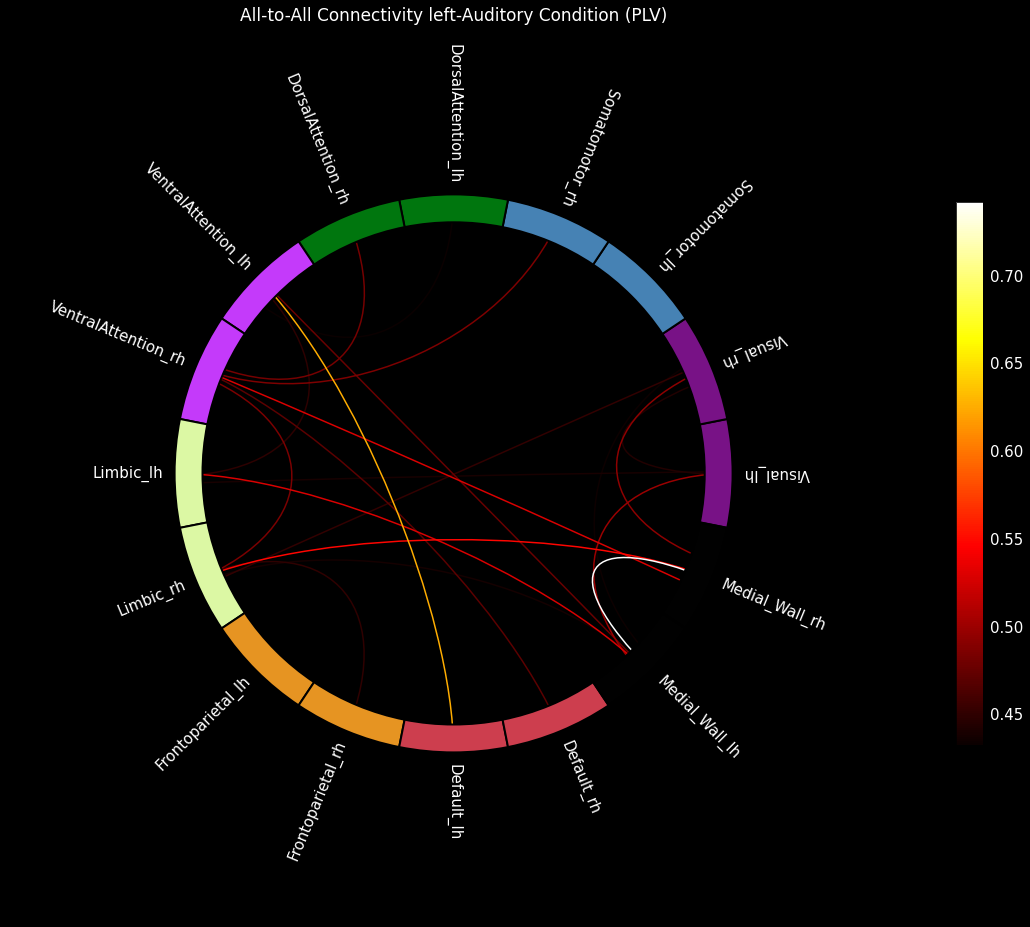

In [163]:
# we will use this function since the with the main function we cannot control the size of the plot in the current
# version of mne-connectivity
from mne.viz.circle import _plot_connectivity_circle

# label colors
atlas_labels = mne.read_labels_from_annot('fsaverage',
                                          'Yeo2011_7Networks_N1000',
                                          subjects_dir='data/')
label_colors = [label.color for label in atlas_labels]

# indices
l1 = [int(conn.coords['roi'].to_numpy()[i].split('-')[1]) - 1 
  for i in range(len(conn.coords['roi']))]

l2 = [int(conn.coords['roi'].to_numpy()[i].split('-')[-1]) - 1 
  for i in range(len(conn.coords['roi']))]
indices = np.array([l1, l2])

fig, ax = plt.subplots(figsize=(20, 20), facecolor='black',
                       subplot_kw=dict(polar=True))

_plot_connectivity_circle(conn.to_numpy()[:, 0],
                         labels,
                         indices,
                         n_lines=20,
                        #  node_angles=node_angles,
                         node_colors=label_colors,
                         colorbar_size=0.5,
                         fontsize_title=17,
                         fontsize_names=15,
                         fontsize_colorbar=15,
                         title='All-to-All Connectivity left-Auditory '
                               'Condition (PLV)',
                               ax=ax,
                        interactive=False,
                        show=False)